In [3]:
import requests
import string
from pprint import pprint
import re
import os
import tempfile
from bs4 import BeautifulSoup
from collections import Counter, OrderedDict
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.stats.stats import pearsonr
from palettable.tableau import Tableau_20 as color_palette
from decimal import Decimal
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
matplotlib.rc('font', **font)
hookRegex = re.compile(r'\[.*\]')
tireRegex = re.compile(r' -')
engnameRegex = re.compile(r'_\(\w+\)')
chars_to_remove = string.punctuation.replace('-', '') + '—„“»«'
api_url = 'http://api.genius.com'
base_url = 'http://genius.com'
headers = {'Authorization': 'Bearer ' + open('./.bearer_token.txt', 'r').read().rstrip('\n')}

In [4]:
def remove_unnecessary(textfile):
    return tireRegex.sub('', hookRegex.sub('',textfile).translate(str.maketrans('','',chars_to_remove)))

class Artist(object):
    artist_id = ''
    songlist = []
    artist_name = ''
    def __init__(self, name, artist_id=False, write_id=False, printout=False):
        self.name = name
        self.printout = printout
        if artist_id:
            self.artist_id = artist_id
        else:
            if self.printout:
                print("Finding the ID of an artist " + self.name)
            search_url = api_url + '/search'
            data = {'q': self.name}
            response = requests.get(search_url, params=data, headers=headers)
            self.artist_id = response.json()['response']['hits'][0]['result']['primary_artist']['api_path']
        if self.printout:
            print("ID of an artist " + self.name + " is " + self.artist_id[9:])
        self.artist_name = response.json()['response']['hits'][0]['result']['primary_artist']['name']

        if write_id:
            with open('./artists_id_list.txt', 'r+') as textfile:
                if self.artist_id in textfile.read():
                    pass
                else:
                    textfile.write(textfile.read() + '\n' + self.artist_name + "  -  " + self.artist_id)

        list_of_songs = []
        if self.printout:
            print("Getting the list of songs")
        for page in range(1,4):
            res = requests.get(api_url + self.artist_id + '/songs?sort=popularity&per_page=50&page=' + str(page), headers=headers)
            if self.printout:
                print("Going through page " + str(page))
            for song in res.json()['response']['songs']:
                if ("Ft." in song['full_title']) | ("Remix" in song['full_title']):
                    if self.printout:
                        print(song['full_title'] + " is a feat, skipping")
                elif song['primary_artist']['api_path'] != self.artist_id:
                    if self.printout:
                        print("Primary artist is not the right one")
                else:
                    song_url = song['url']
                    list_of_songs.append(song_url)
        self.songlist = list_of_songs

    def perform_task(self):
        with open("./lyrics/" + self.artist_name.replace(' ', '_') + '_lyrics.txt', 'w') as lyricsfile:
            for song in self.songlist:
                if self.printout:
                    print(str(self.songlist.index(song)) + " Now scraping " + song[19:])
                page_url = song
                res = requests.get(page_url, headers=headers)
                page = requests.get(page_url)
                html = BeautifulSoup(page.text, 'html.parser')
                lyrics = html.find(class_='lyrics').get_text()
                lyricsfile.write(lyrics)
        return


In [13]:
def get_first_ten_k(oldlocation, newlocation):
    oldfile = open(oldlocation, 'r')
    newfile = open(newlocation, 'w')
    l = remove_unnecessary(oldfile.read()).lower().split()
    if len(l) > 9500:
        for word in l[:9500]:
            newfile.write(word.replace("ё", "е") + "\n")
        oldfile.close()
        newfile.close()
    else:
        print(oldlocation[:-4] + " has not enough lyrics")
        os.remove(newlocation)
    return

def get_unique_words(total_words, artist_count):
    shared_items = set(total_words.items()) & set(artist_count.items())
    return shared_items

def get_total_file(directory, location):
    with open(location, 'w') as total_file:
        for lyrics in os.listdir(directory):
            total_file.write(open(directory+lyrics, 'r').read())
    return



def get_percentage(words, total):
    return float(words)*100/float(total)

def ord_dict(input_dict):
    return OrderedDict(sorted(input_dict.items(), key = itemgetter(1), reverse = True))


In [6]:
def plot_barchart(input_dict, savedname=False, y_label=False, graph_label=False, width=False, normline=False):
    fig = plt.figure(figsize=(20, 10), dpi=100)
    ax = fig.add_subplot(111)
    ind = np.arange(len(input_dict))                # the x locations for the groups
    if width:
        pass
    else:
        width=0.70
    rects1 = ax.bar(ind, input_dict.values(), width,
                    color='#BBBBBB')

    for rect, label in zip(rects1, input_dict.values()):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, str(label), ha='center', va='bottom')
    if y_label:
        ax.set_ylabel(y_label, fontsize=26)
    if graph_label:
        fig.suptitle(graph_label, fontsize=30)
    ax.set_xticks(ind)
    ax.set_xlim(0-width, len(ind))
    ax.tick_params(axis='both', which='major', labelsize=20)
    xtickNames = ax.set_xticklabels(input_dict.keys(), rotation='vertical')
    if normline:
        ax.plot((len(ind), 0), (0,100))
    if savedname:
        plt.savefig(savedname, bbox_inches='tight')
    plt.show()

def plot_freq_line(input_dict, savedname=False, y_label=False, graph_label=False, width=False, normline=False):
    fig = plt.figure(figsize=(20, 10), dpi=100)
    ax = fig.add_subplot(111)
                    # the x locations for the groups
    if width:
        pass
    else:
        width=0.70
    barlist = []
    labels = []
    colors = color_palette.hex_colors
    for item, color in zip(input_dict, colors):
        ind = np.arange(len(input_dict[item]))
        rects1 = ax.plot(ind, input_dict[item].values(), width,
                    color=color)
        barlist.append(rects1[0])
        labels.append(item)
    xlim1 = 5
    xlim2 = 40
    if y_label:
        ax.set_ylabel(y_label, fontsize=26)
    if graph_label:
        fig.suptitle(graph_label, fontsize=30)
    ax.set_xticks(ind)
    ax.set_xlim(xlim1-width, xlim2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks(np.arange(xlim1,xlim2,5))
    ax.legend(barlist, labels)
    if normline:
        ax.plot((len(ind), 0), (0,100))
    if savedname:
        plt.savefig(savedname, bbox_inches='tight')
    plt.show()

def plot_freq_barchart(input_dict, savedname=False, y_label=False,
                       graph_label=False, width=False, normline=False,
                       averline=False):
    fig = plt.figure(figsize=(20, 10), dpi=100)
    ax = fig.add_subplot(111)
                    # the x locations for the groups
    if width:
        pass
    else:
        width=0.70
    barlist = []
    labels = []
    ind = np.arange(len(input_dict))
    rects1 = ax.bar(ind, input_dict.values(), width,
                    color='#BBBBBB')

    if y_label:
        ax.set_ylabel(y_label, fontsize=26)
    if graph_label:
        fig.suptitle(graph_label, fontsize=30)
    ax.set_xticks(np.arange(0,100,10))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlim(0,100)
    if normline:
        ax.plot((len(ind), 0), (0,100))
    if averline:
        ax.plot(ind, averline.values(), width, color='red', drawstyle='steps-mid')
        ax.fill_between(ind, averline.values(), 0, color='red',alpha=0.4, step='mid')
    if savedname:
        plt.savefig(savedname, bbox_inches='tight')
    plt.show()


In [7]:
class Lyric_file(object):
    the_text = ''
    the_list = []
    the_counter = {}
    the_total_words = 0
    the_total_diff_words = 0
    artist_name = ''
    def __init__(self, location):
        self.location = location
        self.the_text = open(self.location, 'r').read()
        self.the_list = self.the_text.split()
        self.the_counter = Counter(self.the_list)
        self.the_total_words = len(self.the_list)
        self.the_total_diff_words = len(self.the_counter)
        self.artist_name = engnameRegex.sub('', location[13:-11]).replace('_', ' ')

    def get_most_common(self, number):
        res_dict = {}
        for item in self.the_counter.most_common(number):
            res_dict[item[0]] = item[1]
        return res_dict

    def get_most_common_percentage(self, number):
        res_dict = {}
        for word in self.get_most_common(number):
            res_dict[word] = get_percentage(self.get_most_common(number)[word], self.the_total_words)
        return res_dict

    def get_percentage_of_word(self, word):
        return get_percentage(self.the_counter[word],self.the_total_words)

    def get_vocab_size(self):
        return len(self.the_list)/self.the_total_diff_words
    def get_percentage_counter(self):
        res_dict = {}
        for item in self.the_counter:
            res_dict[item] = self.get_percentage_of_word(item)
        return res_dict

    def find_checks(self, number):
        y = np.asarray(list(ord_dict(self.get_percentage_counter()).values()))
        for count in range(1,number):
            for item in range(0,len(y)):
                if np.sum(y[:item])>(100/number)*count:
                    res_dict[int(count/number*100)] = round(item*100/self.the_total_diff_words,3)
                    break
        return ord_dict(res_dict)

    def find_check_values(self, number):
        y = np.asarray(list(ord_dict(self.get_percentage_counter()).values()))
        y = y.reshape(number, int(len(y)/number)+1)
        return 
#
    def get_as_arr(self):
        return np.asarray(list(ord_dict(self.the_counter).values()))

    def plot_percentiles(self, number, savedname=False, graph_label=False):
        plot_freq_barchart(self.find_checks(number),
                      savedname="./figs/percentiles/"+self.artist_name.replace(' ', '_')+'.png',
                     y_label="Number of words",
                     graph_label=self.artist_name + ", how many words make each " + str(int(100/number)) + " % of lyrics",
                     width=0.8,
                     normline=True)


    def plot_new_distribution(self, savedname=False, graph_label=False):
        y = np.asarray(list(ord_dict(self.the_counter).values()))*100/self.the_total_words
        x = np.arange(self.the_total_diff_words)*100/self.the_total_diff_words
        fig = plt.figure(figsize=(20, 10), dpi=200)
        ax = fig.add_subplot(111)

        def find_checks(number):
            res_list = [0]
            for count in range(1,number):
                for item in range(0,len(y)):
                    if np.sum(y[:item])>10*count:
                        res_list.append(item)
                        break
            res_list.append(len(y))
            return res_list

        def plot_fill(wh_from, wh_to, color):
            ax.plot(x[wh_from:wh_to], y[wh_from:wh_to], color=color, drawstyle='steps-pre')
            ax.fill_between(x[wh_from:wh_to], y[wh_from:wh_to], 0, color=color, step="pre", alpha=0.5)
        ylim = 4.5
        xlim = 10
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
        def get_colors(number):
            res_list = []
            for col in np.arange(0,1,1/number):
                res_list.append(str(col))
            return res_list

        colors = get_colors(10)
        checkpoints = find_checks(10)
        for number, colour in zip(checkpoints[:-1], colors):
            plot_fill(number, checkpoints[checkpoints.index(number)+1]+1, color=colour)
        plt.xticks(np.arange(0, xlim, .2), rotation='vertical', fontsize=10)
        plt.yticks(np.arange(0, ylim, .2), fontsize=10)
        ax.set_ylabel('Percentage of one word %')
        ax.set_xlabel('Percentage of all words %')
        if graph_label:
            fig.suptitle(self.artist_name + " frequency distribution", fontsize=22)
        if savedname:
            plt.savefig('./figs/distributions/' + self.artist_name.replace(' ', "_") + '.png', bbox='tight')
        plt.show()


In [8]:
class File_dir(object):
    file_list = []
    total_lyric = None
    total_counter = None
    def __init__(self, location, total_file):
        self.location = location
        self.total_file = total_file

        self.total_lyric = Lyric_file(total_file)
        self.total_counter = self.total_lyric.the_counter


        res_list = []
        for file in os.listdir(location):
            if "direct" in file:
                continue
            res_list.append(location + file)
        self.file_list = res_list
        return

    def get_uniq_words(self):
        res_dict = {}
        for artist in self.file_list:
            obj = Lyric_file(artist)
            res_dict[obj.artist_name] = len(get_unique_words(self.total_counter, obj.the_counter))
        return ord_dict(res_dict)

    def get_top_words(self, number):
        res_dict = {}
        for artist in self.file_list:
            obj=Lyric_file(artist)
            res_dict[obj.artist_name] = round(sum(list(obj.get_most_common_percentage(number).values())), 2)
        return ord_dict(res_dict)


    def get_wordgroup_percentage(self, wordlist):
        res_dict = {}
        for artist in self.file_list:
            obj = Lyric_file(artist)
            total_self_percentage = 0
            for word in wordlist:
                total_self_percentage += obj.get_percentage_of_word(word)
            res_dict[obj.artist_name] = round(total_self_percentage, 2)
        return ord_dict(res_dict)

    def plot_wordgroup(self, wordlist, savedname, y_label=False, graph_label=False):
        plot_barchart(self.get_wordgroup_percentage(wordlist),
           savedname,
           y_label=y_label,
                     graph_label=graph_label)

    def plot_uniq_words(self, savedname, y_label=False, graph_label=False, normline=False):
        plot_barchart(self.get_uniq_words(),
                      savedname,
                      y_label=y_label,
                     graph_label=graph_label,
                     normline=normline)

    def plot_distributions(self, savedname=False, graph_label=False):
        for artist in self.file_list:
            obj = Lyric_file(artist)
            obj.plot_distribution(savedname=savedname, graph_label=graph_label)

    def plot_top_words(self, number, savedname, graph_label=False, y_label=False):
        plot_barchart(self.get_top_words(number),
                      savedname,
                      graph_label=graph_label,
                     y_label=y_label)
    def plot_new_distributions(self, savedname=False, graph_label=False):
        for artist in self.file_list:
            obj = Lyric_file(artist)
            obj.plot_new_distribution(savedname=savedname, graph_label=graph_label)
    def plot_percentiles(self, number, savedname=False, graph_label=False):
        for artist in self.file_list:
            obj = Lyric_file(artist)
            obj.plot_percentiles(number, savedname=savedname, graph_label=graph_label)
    def get_percent_dict(self, number, how_many=False):
        res_dict = {}

        if not how_many:
            how_many = len(self.file_list)+1
        for artist in self.file_list[:how_many]:
            obj = Lyric_file(artist)
            res_dict[artist[13:-11]] = obj.find_checks(number)
        return res_dict

In [9]:
### USING THE STUFF CREATED ABOVE, SCRAPE ALL NON-FEAT LYRICS FOR TH ARTISTS IN artists_source.txt

with open('./artists_source.txt', 'r') as id_list:
    artistlist = id_list.readlines()
    for artist in artistlist:
        the_artist = Artist(artist.rstrip("\n"), write_id=True)
        print("Now scraping " + the_artist.artist_name + ", " + str(len(artistlist) - 1 - artistlist.index(artist)) + " remaining")
        the_artist.perform_task()

Now scraping Oxxxymiron, 26 remaining
Now scraping макулатура (makulatura), 25 remaining
Now scraping Гуф (Guf), 24 remaining
Now scraping SidxRam, 23 remaining
Now scraping Слава КПСС (Slava KPSS), 22 remaining
Now scraping ЛСП (LSP), 21 remaining
Now scraping Скриптонит (Scriptonite), 20 remaining
Now scraping Каста (Kasta), 19 remaining
Now scraping Кровосток (Krovostok), 18 remaining
Now scraping Big Russian Boss, 17 remaining
Now scraping Bumble Beezy, 16 remaining
Now scraping Pharaoh, 15 remaining
Now scraping Rickey F, 14 remaining
Now scraping СД (SD aka Sadist), 13 remaining
Now scraping Хаски (Husky), 12 remaining
Now scraping Face, 11 remaining
Now scraping ATL, 10 remaining
Now scraping Noize MC, 9 remaining
Now scraping Баста (Basta), 8 remaining
Now scraping Slim, 7 remaining
Now scraping Schokk & Oxxxymiron, 6 remaining
Now scraping Рем Дигга (Rem Digga), 5 remaining
Now scraping Yanix, 4 remaining
Now scraping Anacondaz, 3 remaining
Now scraping Kizaru, 2 remaining
Now

In [12]:
new_artist = Artist("Сага об орлах и канарейках (Saga ob orlah i kanareykah)", printout=True)
new_artist.perform_task()

Finding the ID of an artist Сага об орлах и канарейках (Saga ob orlah i kanareykah)
ID of an artist Сага об орлах и канарейках (Saga ob orlah i kanareykah) is 24799
Getting the list of songs
Going through page 1
Сага об орлах и канарейках (Saga ob orlah i kanareykah) by Schokk (Ft. Oxxxymiron) is a feat, skipping
Жук в муравейнике (Beetle in an anthill) by Oxxxymiron (Ft. Schokk) is a feat, skipping
Primary artist is not the right one
Что такое биф? (What is a beef?) by Oxxxymiron (Ft. Schokk) is a feat, skipping
ТУПАКАЛИПС (Tupacalypse) by Schokk (Ft. Adamant (Russia)) is a feat, skipping
Дегенеративное искусство (Degenerativnoe Iskusstvo) by Schokk (Ft. Oxxxymiron) is a feat, skipping
Мысли пачкают мозги (Myisli Pachkayut Mozgi) by Schokk (Ft. Oxxxymiron) is a feat, skipping
HHP by Schokk (Ft. Gera Berlin) is a feat, skipping
В Африке дети не носят Palace (In Africa...) by Schokk (Ft. Redo) is a feat, skipping
Operation Payback by Schokk (Ft. Oxxxymiron & СД (SD aka Sadist)) is a fea

In [15]:
for file in os.listdir('./lyrics/'):
    get_first_ten_k('./lyrics/' + file, './cut_lyrics/' + file)

get_total_file('./cut_lyrics/', './total_cut.txt')
get_total_file('./lyrics/', './total.txt')

./lyrics/Rickey_F_lyrics has not enough lyrics
./lyrics/Джиган_(Geegun)_lyrics has not enough lyrics
./lyrics/Big_Russian_Boss_lyrics has not enough lyrics


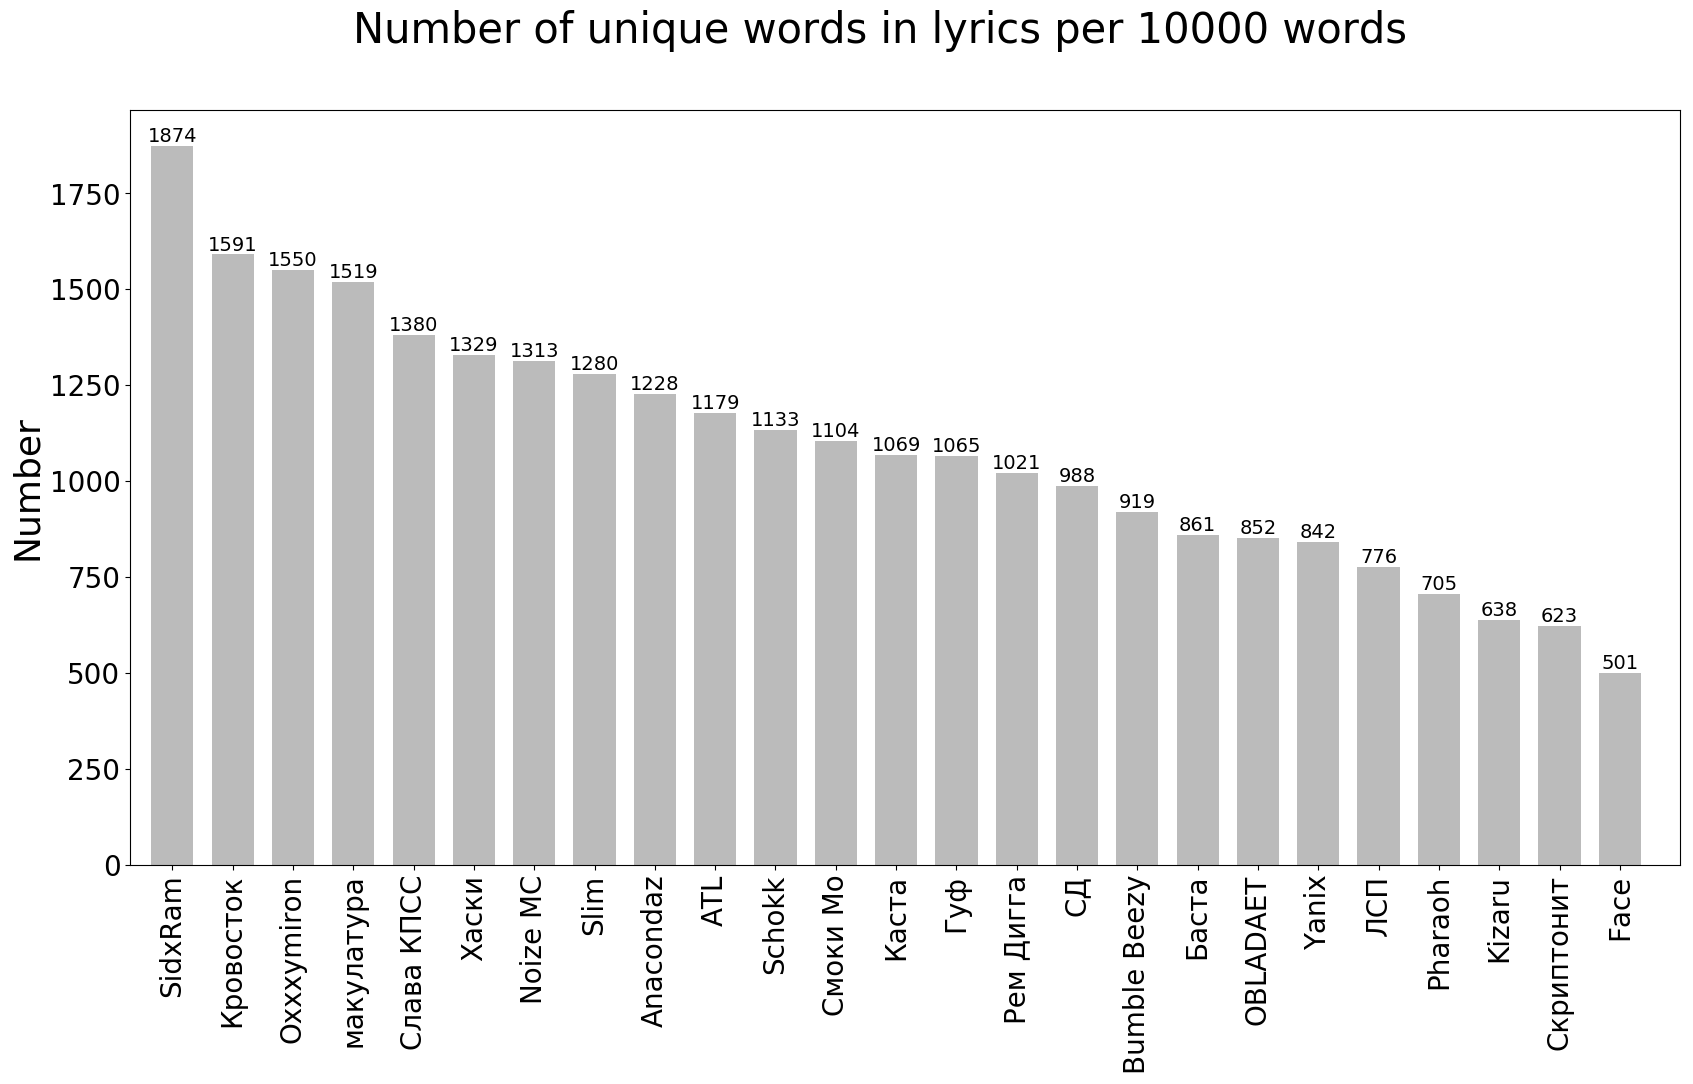

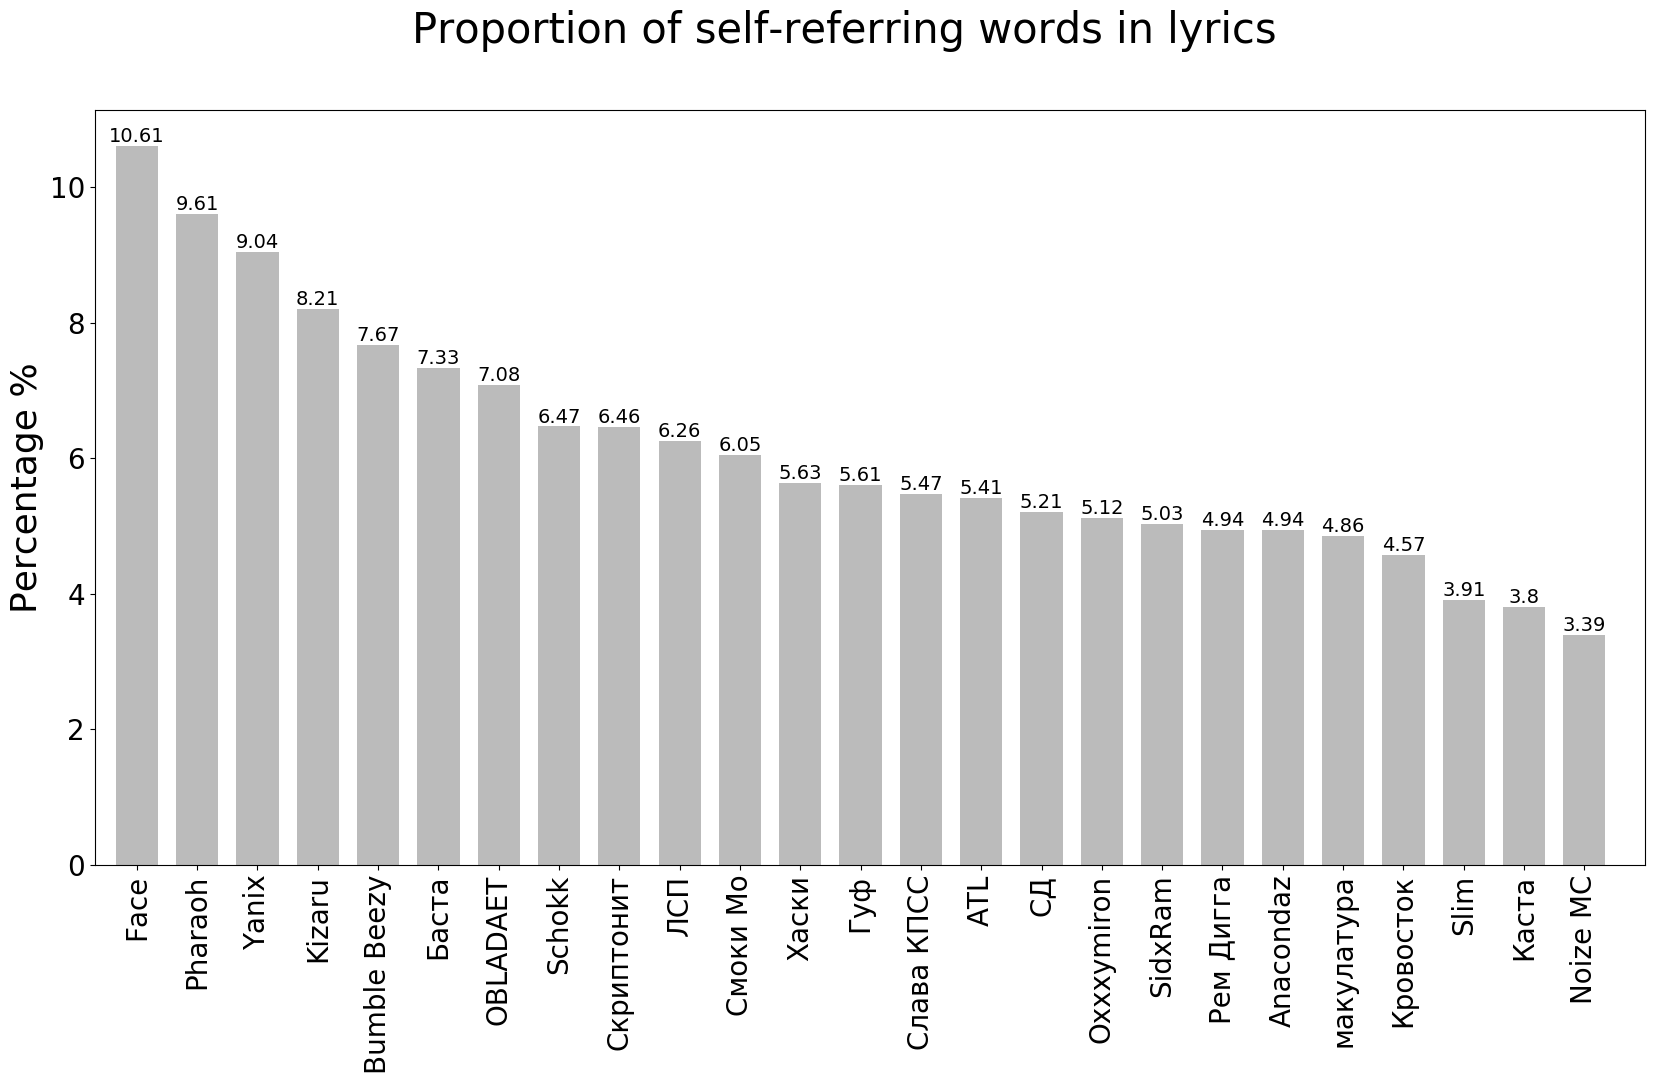

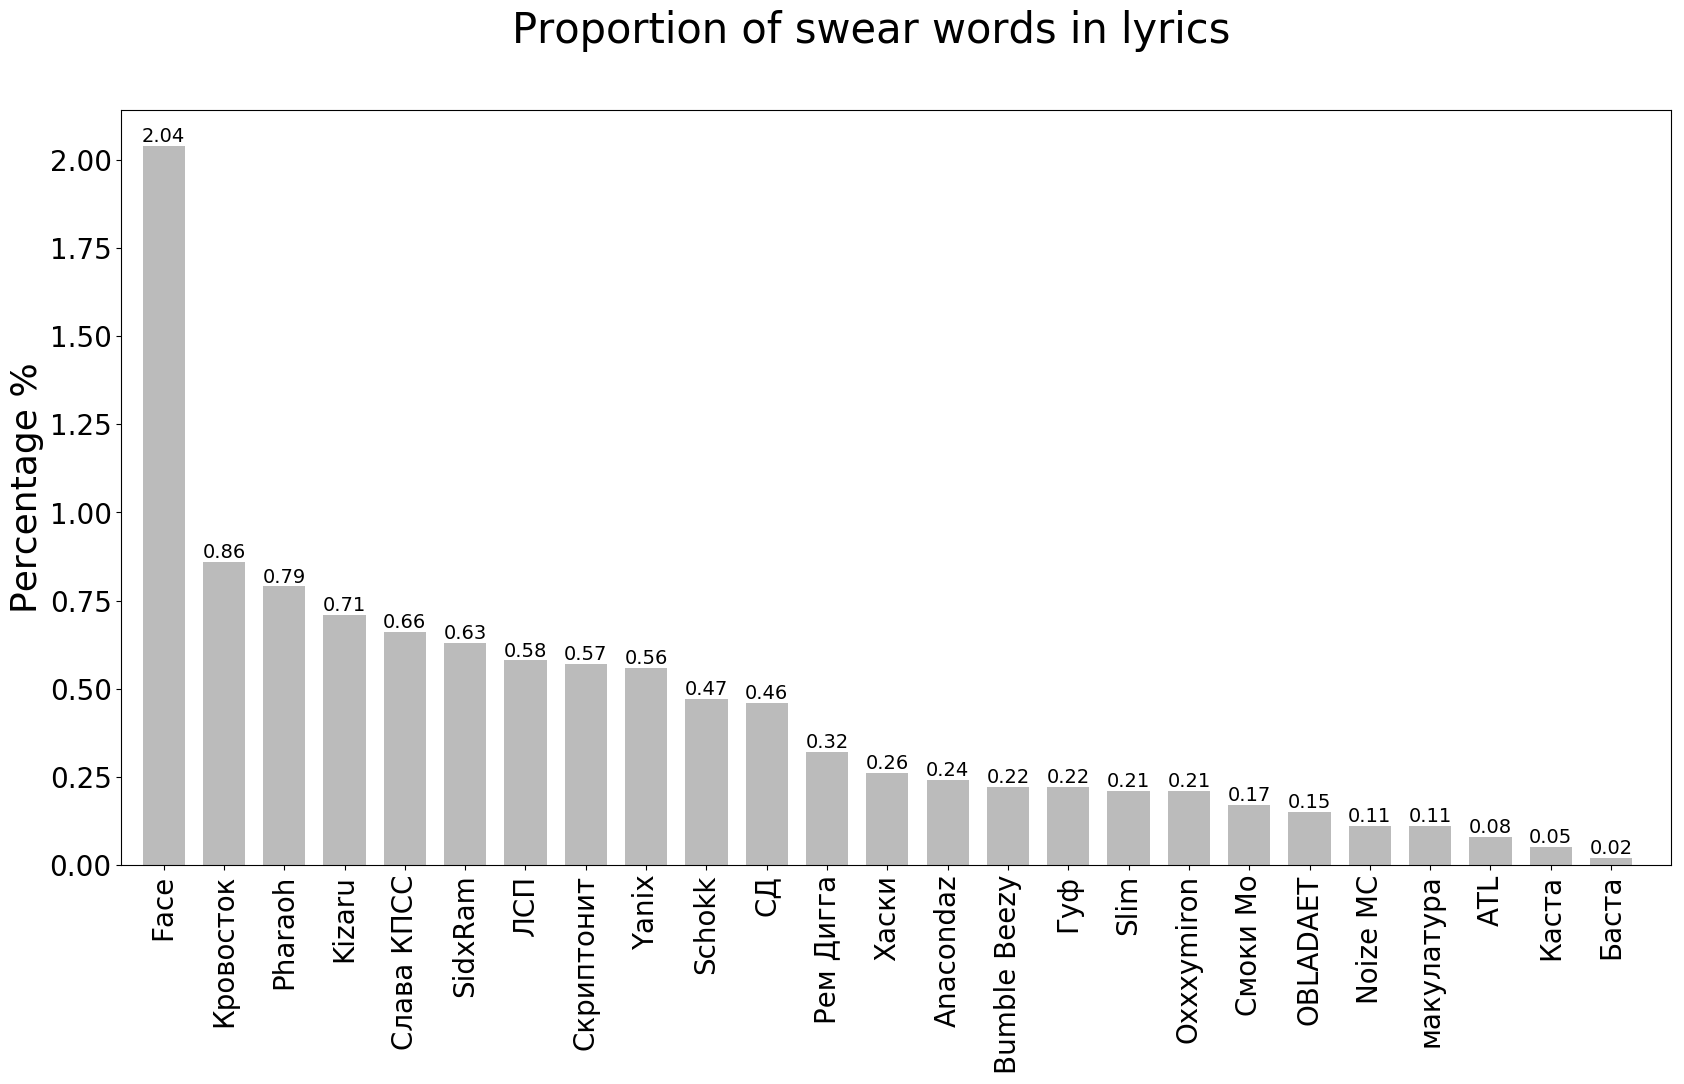

In [16]:
cut_dir = File_dir('./cut_lyrics/', './total_cut.txt')
self_referring_words = ["я", "мой", "мы", "мне", "меня", "мои", "нас", "мое", "наше", "моя"]
swear_words = ["блядь", "хуй", "хуйня", "ебать", "ебал", "пиздец", "пизда", "ебал", "пидор", "говно", "хуево", "сука", "сучка", "соска", "сосать", "член", "шлюха", "уебан", "уебище"]

cut_dir.plot_uniq_words('./figs/unique_words.png', 
                        y_label="Number",
                       graph_label="Number of unique words in lyrics per 10000 words")


cut_dir.plot_wordgroup(self_referring_words,
           './figs/self_love.png', 
           y_label="Percentage %",
                      graph_label="Proportion of self-referring words in lyrics")

cut_dir.plot_wordgroup(swear_words,
           './figs/swear_words.png', 
           y_label="Percentage %",
                     graph_label="Proportion of swear words in lyrics")

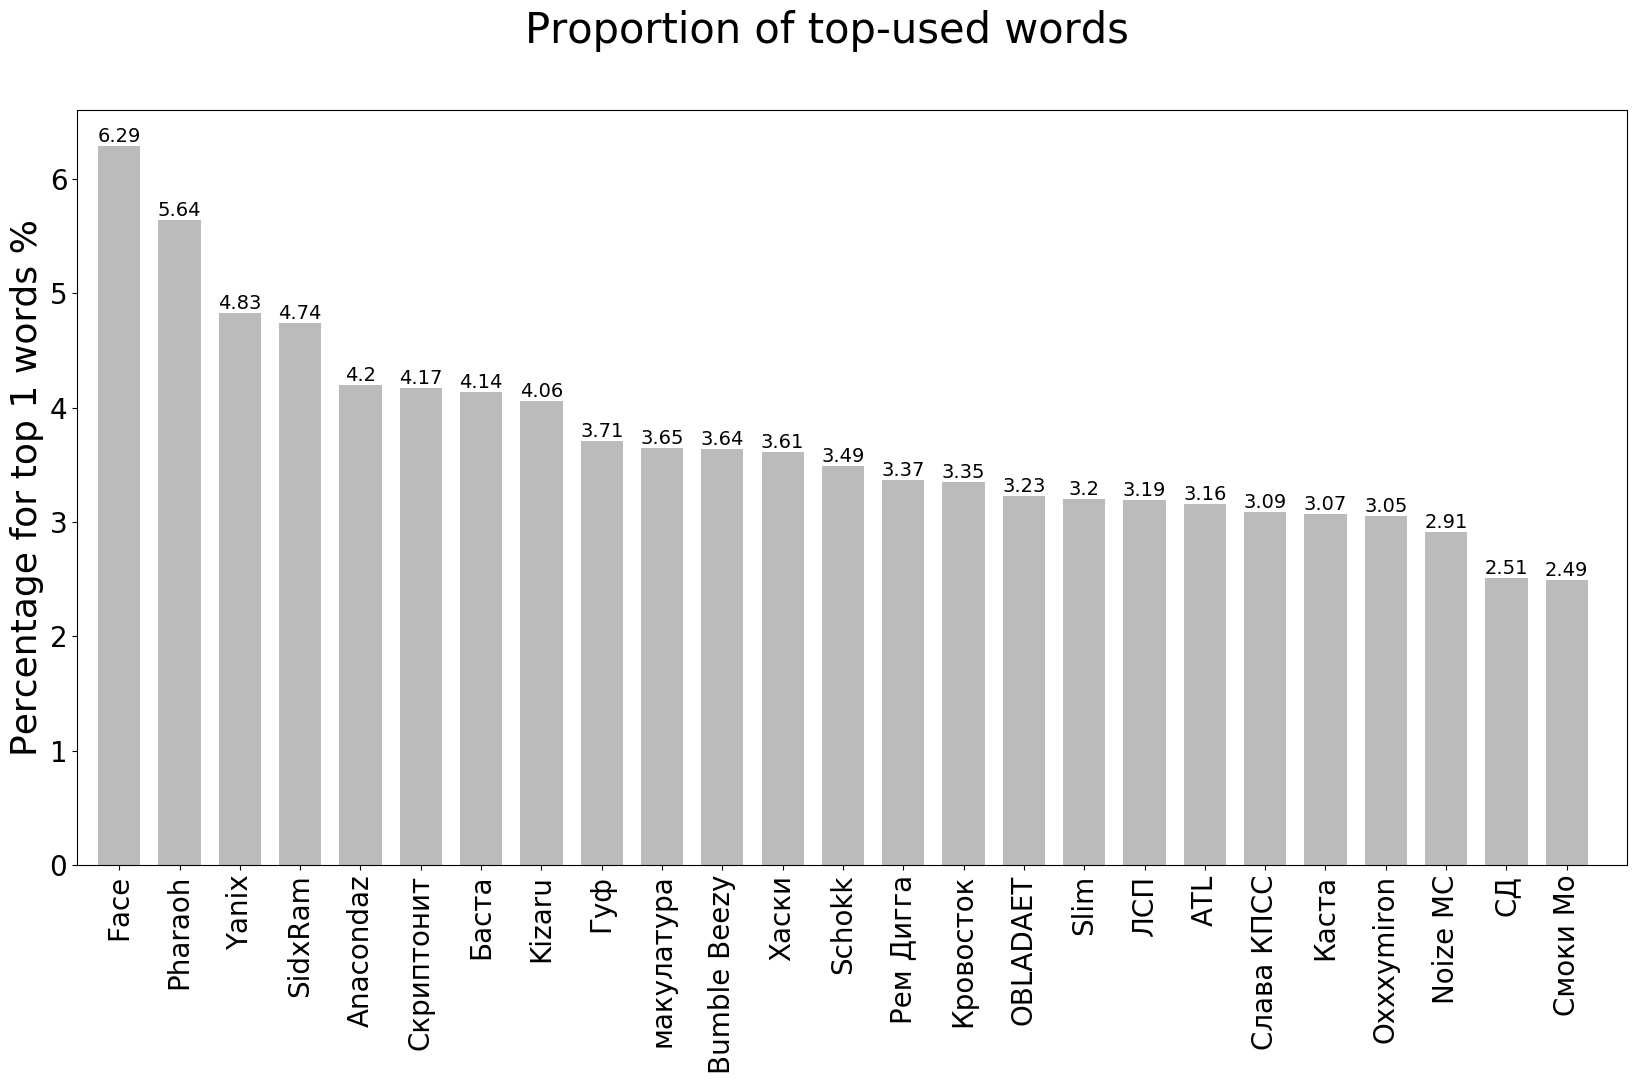

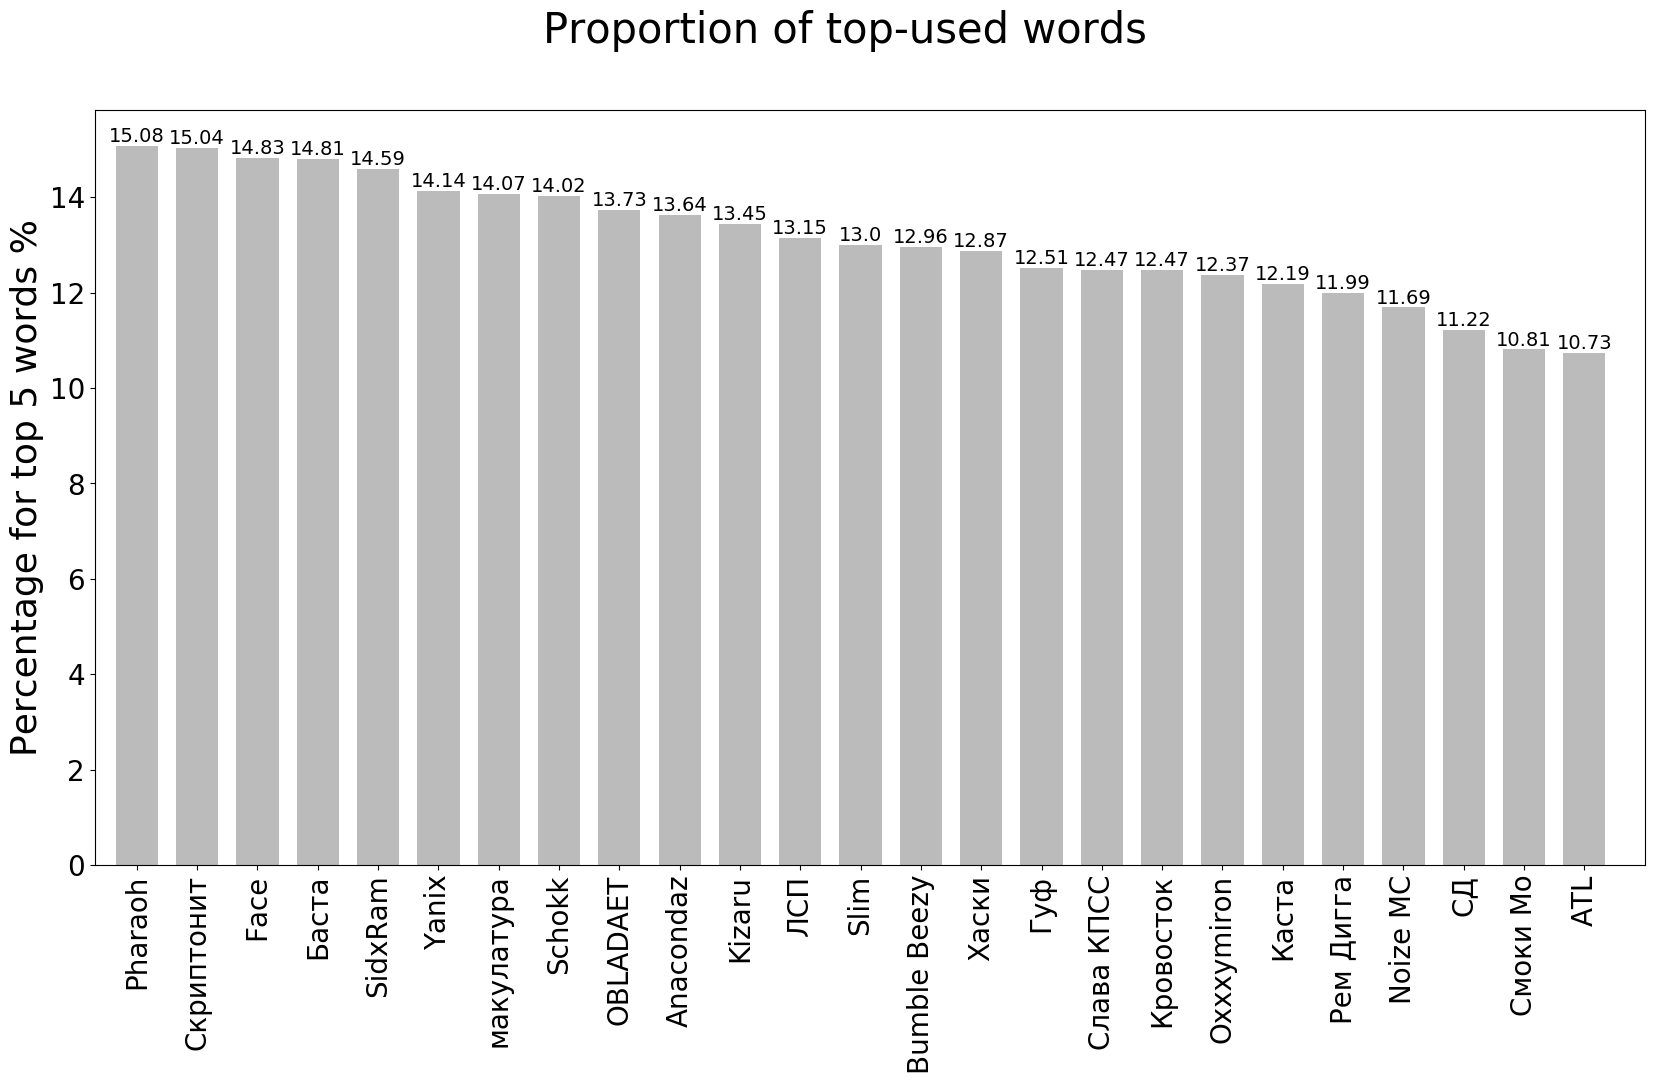

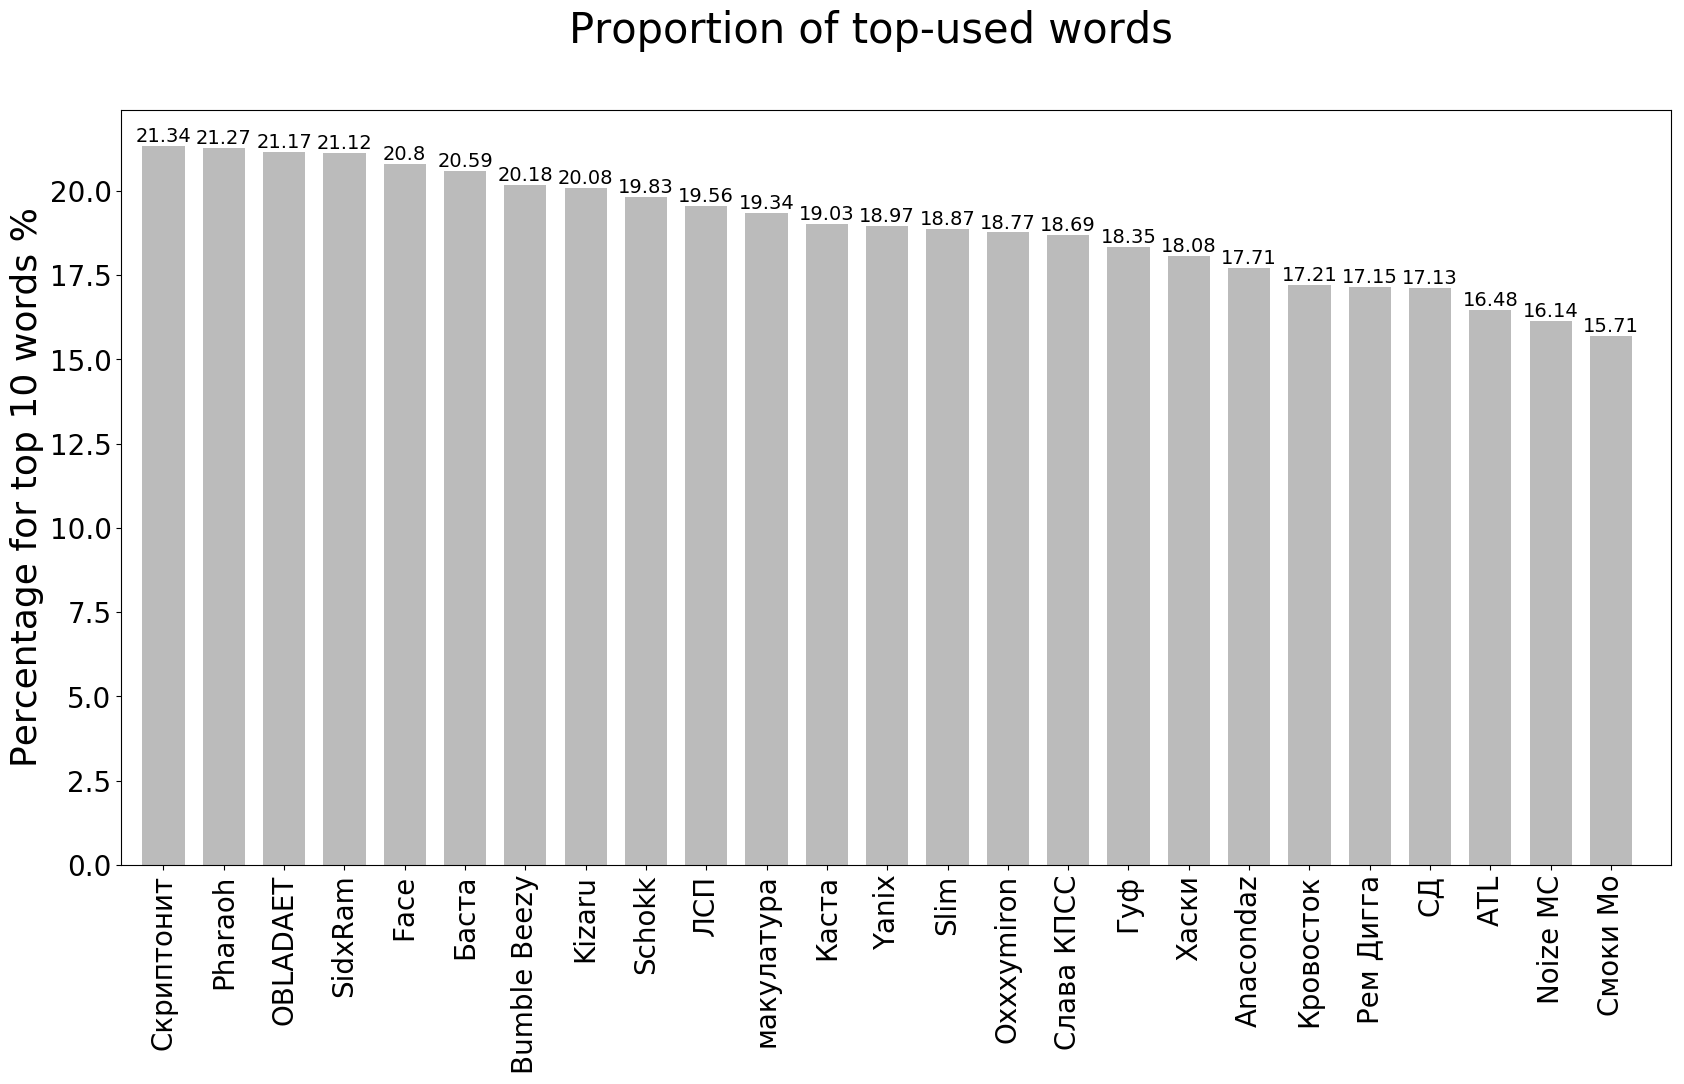

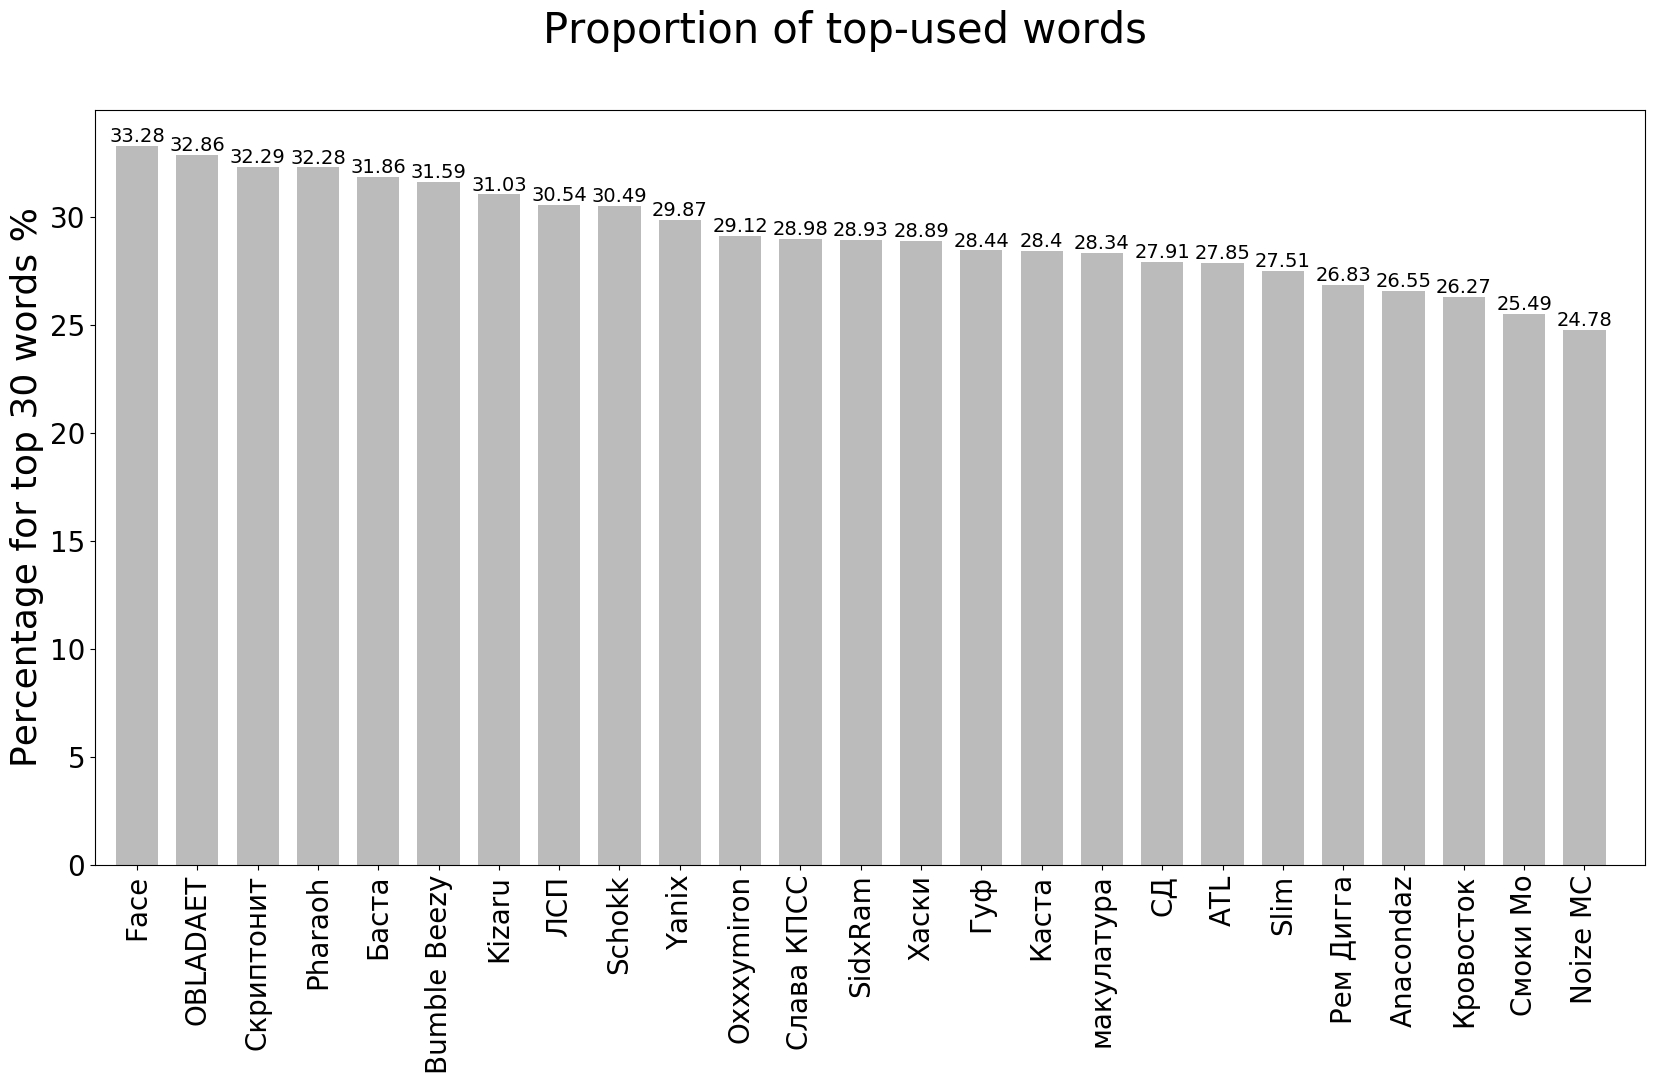

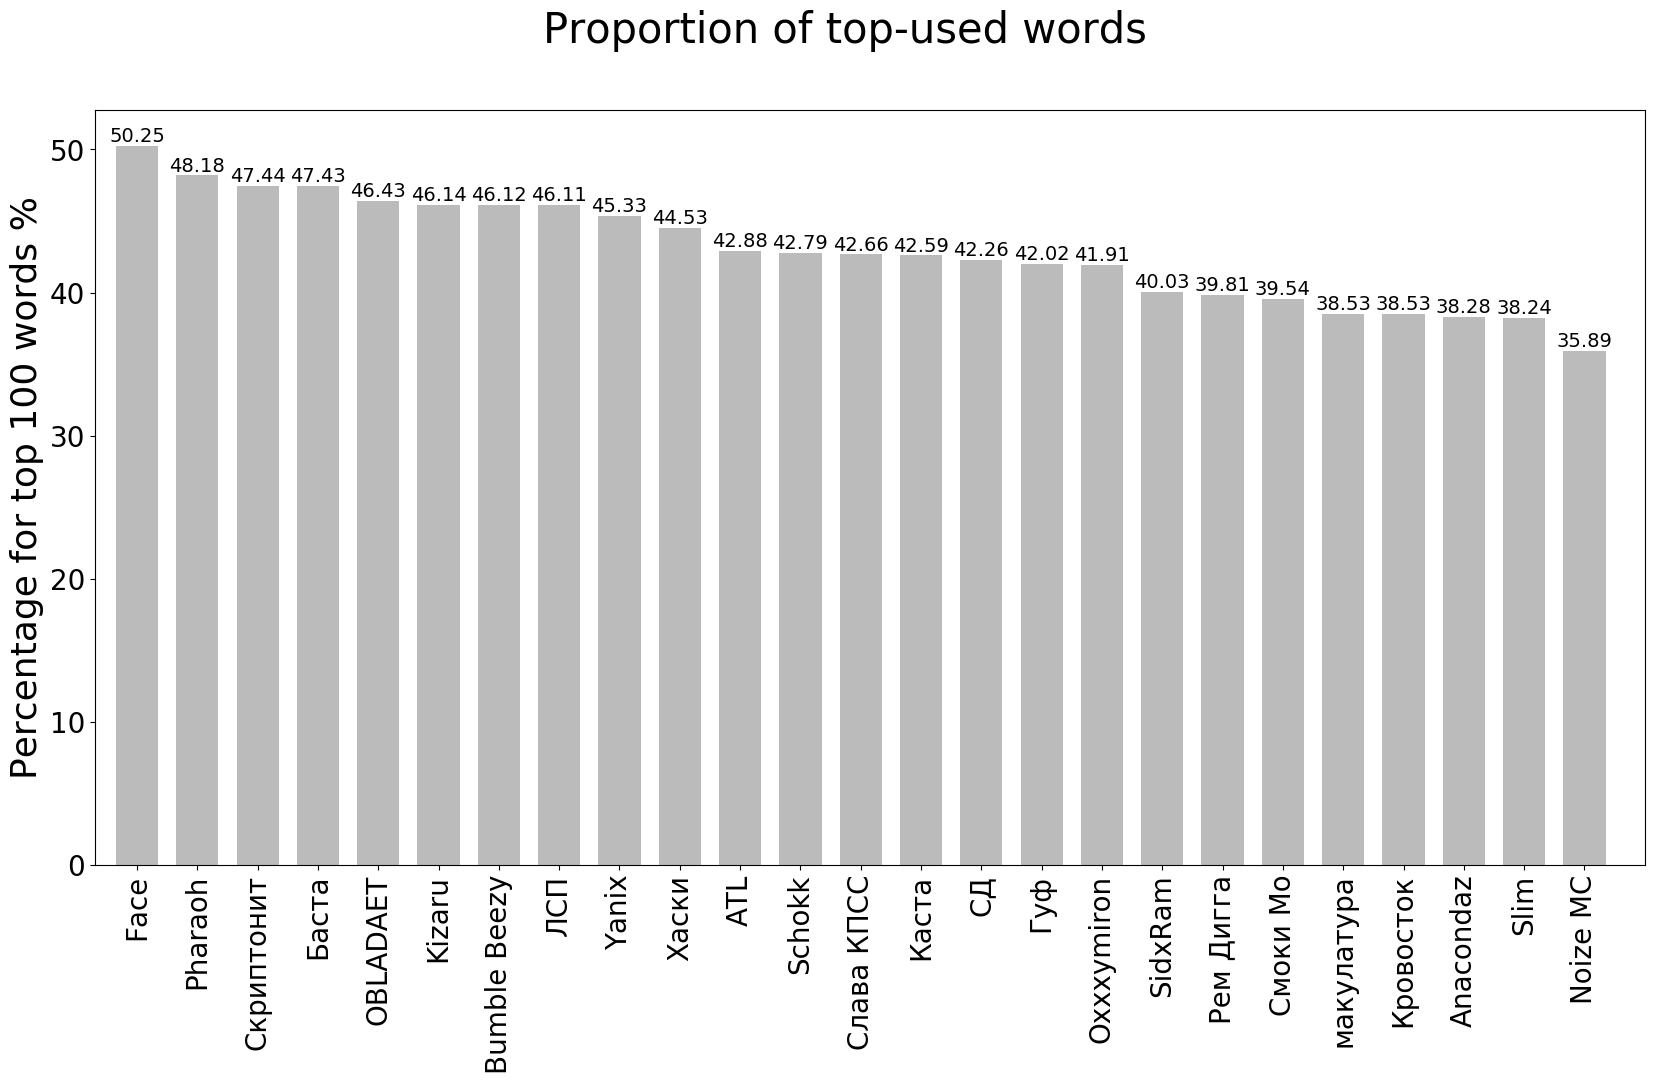

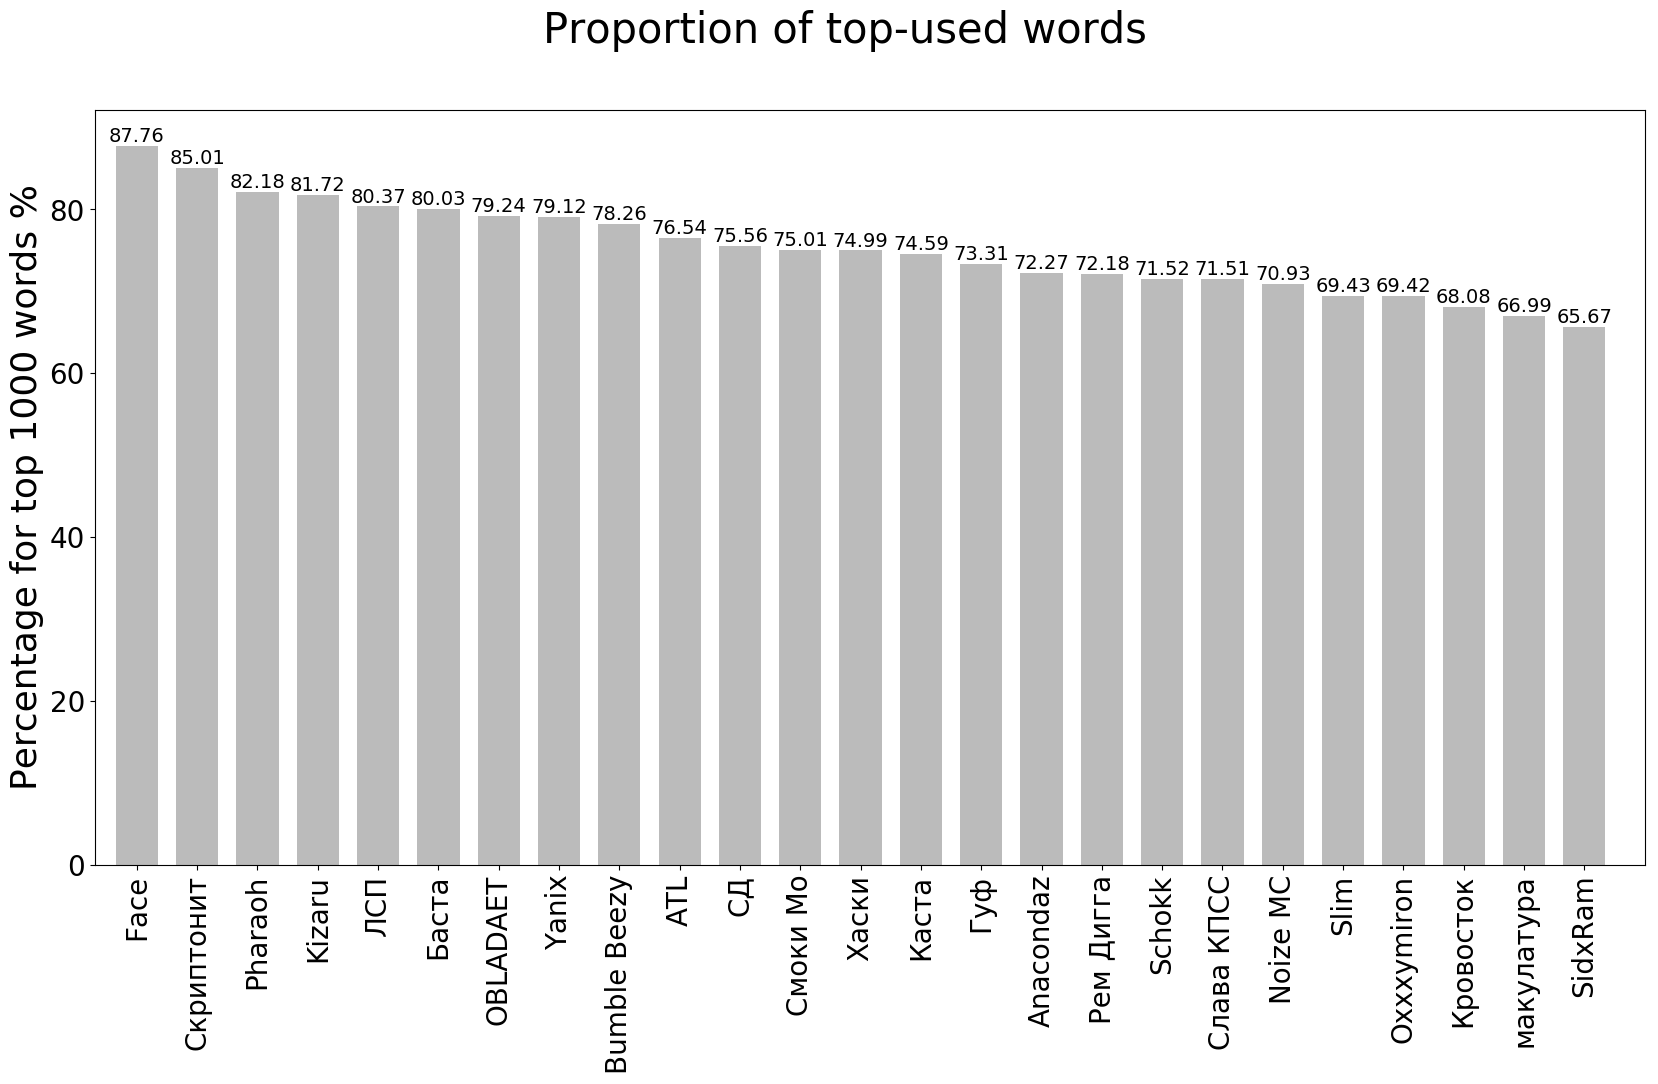

In [17]:
for number in [1,5,10,30,100,1000]:
    cut_dir.plot_top_words(number, 
                           './figs/top_' + str(number) + '_words.png', 
                           graph_label="Proportion of top-used words",
                          y_label="Percentage for top "+str(number)+" words %")

In [ ]:
plot_freq_line(cut_dir.get_percent_dict(100, how_many=10), 
                   savedname="./figs/percentile_freq.png",
                  graph_label="Words percentle distribution",
                  y_label="Percentage %")

In [ ]:
oxy = Lyric_file('./cut_lyrics/Face_lyrics.txt')
arr = oxy.get_as_arr()
for item in arr:
    if arr.cumsum() > oxy.the_total_words/10:
        print(item)
        break

In [18]:
def print_stat_analysis(arr1, arr2):
    res_tuple = pearsonr(arr1, arr2)
    print("Correlation coefficient:")
    print(round(res_tuple[0],2))
    print("2-tailed p-value:")
    print('%.2e' % Decimal(res_tuple[1]))
print("Swearing and self-love")
print_stat_analysis(np.asarray(list(cut_dir.get_wordgroup_percentage(swear_words).values())), np.asarray(list(cut_dir.get_wordgroup_percentage(self_referring_words).values())))
print("\nSwearing and vocab")
print_stat_analysis(np.asarray(list(cut_dir.get_uniq_words().values())), np.asarray(list(cut_dir.get_wordgroup_percentage(swear_words).values())))
print("\nSelf-love and vocab")
print_stat_analysis(np.asarray(list(cut_dir.get_uniq_words().values())), np.asarray(list(cut_dir.get_wordgroup_percentage(self_referring_words).values())))


Swearing and self-love
Correlation coefficient:
0.91
2-tailed p-value:
2.77e-10

Swearing and vocab
Correlation coefficient:
0.89
2-tailed p-value:
2.32e-09

Self-love and vocab
Correlation coefficient:
0.98
2-tailed p-value:
5.08e-17
